In [ ]:
# AYUSH ANAND
# FINAL CAPSTONE PROJECT 3
# HOTEL REVIEWS - SENTIMENT ANALYSIS

# Streamlit App
# https://ayushanand-hotel-reviews-sentiment-analysis.streamlit.app/

In [ ]:
# STEP 1. Problem Definition and Objective:

# Dataset
# https://www.kaggle.com/code/jonathanoheix/sentiment-analysis-with-hotel-reviews/notebook

# The task is to perform three-class sentiment classification (positive, neutral, negative)
# on hotel review text using NLP-based machine learning and deep learning methods.
# The objective is to build, compare, and evaluate ML and DL models that can accurately
# predict sentiment using only textual review data, and to select the best-performing
# model for end-to-end inference and deployment.
# The goal is to compare models, select the best-performing approach,
# and deploy it through an end-to-end inference pipeline and Streamlit app.

In [3]:
# STEP 2. Import required libraries and set random seeds

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [4]:
# STEP 3. Load and inspect the dataset

import pandas as pd
df = pd.read_csv("Hotel_Reviews.csv", low_memory=False)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (515738, 17)


,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,08-03-2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,08-03-2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [5]:
# STEP 4. Label construction for positive, neutral, and negative sentiment

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download("vader_lexicon")

df["review_text"] = (
    df["Positive_Review"].fillna("") + " " +
    df["Negative_Review"].fillna(""))
sia = SentimentIntensityAnalyzer()
df["polarity"] = df["review_text"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["word_balance"] = (
    df["Review_Total_Positive_Word_Counts"] -
    df["Review_Total_Negative_Word_Counts"])

def score_signal(score):
    if score >= 7:
        return 1
    elif score <= 4:
        return -1
    else:
        return 0
df["score_signal"] = df["Reviewer_Score"].apply(score_signal)

def assign_sentiment(row):
    votes = 0
    votes += row["score_signal"]
    votes += 1 if row["polarity"] > 0.1 else -1 if row["polarity"] < -0.1 else 0
    votes += 1 if row["word_balance"] > 5 else -1 if row["word_balance"] < -5 else 0
    if votes >= 2:
        return "positive"
    elif votes <= -2:
        return "negative"
    else:
        return "neutral"
df["sentiment"] = df.apply(assign_sentiment, axis=1)
df["sentiment"].value_counts()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,count
sentiment,
positive,251331
neutral,237157
negative,27250


In [6]:
# STEP 5. Exploratory data analysis (EDA)

df["sentiment"].value_counts()
df["review_length"] = df["review_text"].str.split().str.len()
df["review_length"].describe()

,review_length
count,515738.000000
mean,34.314330
std,38.212243
min,0.000000
25%,11.000000
50%,22.000000
75%,43.000000
max,733.000000


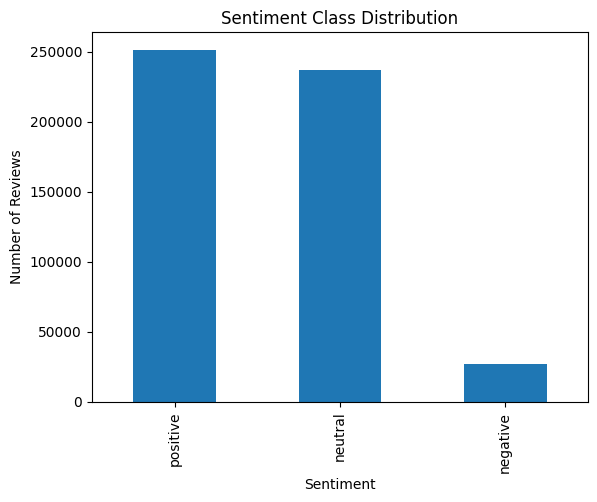

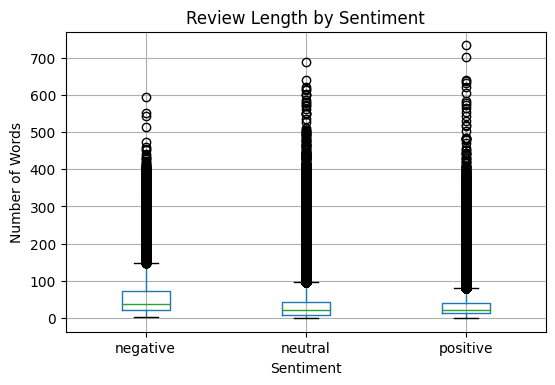

,review_text
0,Reception was a nice beginning Nice big bed f...
1,Friendly staff Hairdryer was not functioning...
2,Friendly and helpful staff and brilliant loca...


In [7]:
import matplotlib.pyplot as plt
df["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

df.boxplot(column="review_length", by="sentiment", figsize=(6,4))
plt.title("Review Length by Sentiment")
plt.suptitle("")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

df.groupby("sentiment")["Reviewer_Score"].mean()
df.groupby("sentiment")["review_text"].apply(
    lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

In [8]:
# STEP 6. Text cleaning and preprocessing

import re
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df["clean_review_text"] = df["review_text"].astype(str).apply(clean_text)
df["clean_review_text"].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,clean_review_text
0,park outside hotel beautiful angry made post a...
1,real complaints hotel great great location sur...
2,location good staff ok cute hotel breakfast ra...
3,great location nice surroundings bar restauran...
4,amazing location building romantic setting boo...


In [9]:
# STEP 7. Train–validation–test data split

from sklearn.model_selection import train_test_split
X = df["clean_review_text"]
y = df["sentiment"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 361016
Validation size: 77361
Test size: 77361


In [10]:
# STEP 8. Feature extraction using Bag of Words and TF-IDF

from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(
    max_features=50000,
    min_df=5,
    ngram_range=(1, 2))

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_val_bow   = bow_vectorizer.transform(X_val)
X_test_bow  = bow_vectorizer.transform(X_test)
print("BoW train shape:", X_train_bow.shape)

BoW train shape: (361016, 50000)


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    max_features=50000,
    min_df=5,
    ngram_range=(1, 2))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf   = tfidf_vectorizer.transform(X_val)
X_test_tfidf  = tfidf_vectorizer.transform(X_test)
print("TF-IDF train shape:", X_train_tfidf.shape)

TF-IDF train shape: (361016, 50000)


In [12]:
# STEP 9.	Baseline machine learning model training

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_tfidf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1)

lr_tfidf.fit(X_train_tfidf, y_train)
y_val_pred_tfidf = lr_tfidf.predict(X_val_tfidf)
print("Logistic Regression (TF-IDF) – Validation Results")
print(classification_report(y_val, y_val_pred_tfidf))


Logistic Regression (TF-IDF) – Validation Results
              precision    recall  f1-score   support

    negative       0.39      0.76      0.52      4087
     neutral       0.78      0.70      0.74     35574
    positive       0.84      0.83      0.83     37700

    accuracy                           0.77     77361
   macro avg       0.67      0.77      0.70     77361
weighted avg       0.79      0.77      0.77     77361



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr_bow = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1)

lr_bow.fit(X_train_bow, y_train)
y_val_pred_bow = lr_bow.predict(X_val_bow)
print("Logistic Regression (BoW) – Validation Results")
print(classification_report(y_val, y_val_pred_bow))

Logistic Regression (BoW) – Validation Results
              precision    recall  f1-score   support

    negative       0.43      0.62      0.51      4087
     neutral       0.75      0.73      0.74     35574
    positive       0.82      0.80      0.81     37700

    accuracy                           0.76     77361
   macro avg       0.66      0.72      0.68     77361
weighted avg       0.77      0.76      0.76     77361



In [14]:
# STEP 10. Advanced deep learning model training

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 50000
MAX_LEN = 200
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val_pad   = pad_sequences(X_val_seq,   maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")
print(X_train_pad.shape)

(361016, 200)


In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc   = label_encoder.transform(y_val)
y_test_enc  = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)
print("Classes:", label_encoder.classes_)

Classes: ['negative' 'neutral' 'positive']


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

model_bilstm = Sequential([
    Input(shape=(MAX_LEN,)),
    Embedding(input_dim=MAX_VOCAB, output_dim=128),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")])
model_bilstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"])

model_bilstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,507,267 (24.82 MB)

 Trainable params: 6,507,267 (24.82 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True)
history = model_bilstm.fit(
    X_train_pad, y_train_enc,
    validation_data=(X_val_pad, y_val_enc),
    epochs=5,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop])

Class weights: {0: np.float64(6.30871122761031), 1: np.float64(0.7248880589522719), 2: np.float64(0.6840105874841084)}
Epoch 1/5
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 88s 28ms/step - accuracy: 0.6893 - loss: 0.6035 - val_accuracy: 0.7838 - val_loss: 0.4711
Epoch 2/5
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 80s 28ms/step - accuracy: 0.8027 - loss: 0.4124 - val_accuracy: 0.7935 - val_loss: 0.4530
Epoch 3/5
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.8339 - loss: 0.3508 - val_accuracy: 0.8000 - val_loss: 0.4555
Epoch 4/5
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 83s 29ms/step - accuracy: 0.8560 - loss: 0.3043 - val_accuracy: 0.8101 - val_loss: 0.4603


In [20]:
# STEP 11.	Model evaluation and performance comparison

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_test_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
print("Logistic Regression (TF-IDF) – Test Results")
print(classification_report(y_test, y_test_pred_tfidf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_tfidf))
y_test_pred_bow = lr_bow.predict(X_test_bow)
print("\nLogistic Regression (BoW) – Test Results")
print(classification_report(y_test, y_test_pred_bow))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_bow))
y_test_pred_dl = model_bilstm.predict(X_test_pad)
y_test_pred_dl = np.argmax(y_test_pred_dl, axis=1)
print("\nBi-LSTM – Test Results")
print(classification_report(y_test_enc, y_test_pred_dl))
print("Confusion Matrix:\n", confusion_matrix(y_test_enc, y_test_pred_dl))

Logistic Regression (TF-IDF) – Test Results
              precision    recall  f1-score   support

    negative       0.38      0.75      0.51      4088
     neutral       0.78      0.70      0.74     35573
    positive       0.84      0.83      0.83     37700

    accuracy                           0.77     77361
   macro avg       0.67      0.76      0.69     77361
weighted avg       0.79      0.77      0.77     77361

Confusion Matrix:
 [[ 3084   955    49]
 [ 4733 24774  6066]
 [  265  6084 31351]]

Logistic Regression (BoW) – Test Results
              precision    recall  f1-score   support

    negative       0.42      0.63      0.51      4088
     neutral       0.75      0.72      0.74     35573
    positive       0.82      0.81      0.82     37700

    accuracy                           0.76     77361
   macro avg       0.67      0.72      0.69     77361
weighted avg       0.77      0.76      0.76     77361

Confusion Matrix:
 [[ 2584  1451    53]
 [ 3320 25787  6466]
 [  207 

In [21]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "Logistic Regression (BoW)",
        "Logistic Regression (TF-IDF)",
        "Bi-LSTM"],
    "Accuracy": [0.76,0.77,0.79],
    "Macro-F1": [0.69,0.69,0.71],
    "Negative Recall": [0.63,0.75,0.88]})

results

,Model,Accuracy,Macro-F1,Negative Recall
0,Logistic Regression (BoW),0.76,0.69,0.63
1,Logistic Regression (TF-IDF),0.77,0.69,0.75
2,Bi-LSTM,0.79,0.71,0.88


In [22]:
# STEP 12. Best model selection

# the Bi-LSTM model achieves superior Macro-F1 and significantly higher recall for
# the minority negative class, making it the best overall model for this task.

In [24]:
# STEP 13. Save trained model and tokenizer/vectorizer

import pickle
model_bilstm.save("bilstm_sentiment_model.keras")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [36]:
# STEP 14. Testing implementation

import re
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
model = load_model("bilstm_sentiment_model.keras")
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
with open("label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

stop_words = set(stopwords.words("english"))
MAX_LEN = 200
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)
def predict_sentiment(text):
    cleaned_text = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    pad = pad_sequences(
        seq, maxlen=MAX_LEN, padding="post", truncating="post"    )
    probs = model.predict(pad, verbose=0)
    pred_idx = np.argmax(probs, axis=1)[0]
    sentiment = label_encoder.inverse_transform([pred_idx])[0]
    confidence = probs[0][pred_idx]

    print("User Input Text:")
    print(text)
    print("\nPredicted Sentiment:", sentiment)
    print("Confidence:", round(float(confidence), 4))
    return sentiment, float(confidence)

predict_sentiment("Bad location and unfriendly staff.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


User Input Text:
Bad location and unfriendly staff.

Predicted Sentiment: negative
Confidence: 0.946


('negative', 0.9459611773490906)

In [ ]:
# STEP 15. Deployment via Streamlit app

# Streamlit App
# https://ayushanand-hotel-reviews-sentiment-analysis.streamlit.app/